In [164]:
import os
import sys
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

In [19]:
def data_tracks_add_LSflag(data_tracks):
    """
    add landsea flag
    """

    lsflag_array = np.zeros((len(data_tracks.tracks),len(data_tracks.times)))*np.nan
    # ERA-5 lat-lon coordinate, 0.25-deg.
    data_lsmask = xr.open_dataset('/neelin2020/RGMA_feature_mask/ERA5_LandSeaMask_regrid.nc4')
    landseamask = data_lsmask.landseamask

    for (n,track) in enumerate(data_tracks.tracks.values):

        meanlon = data_tracks.sel(tracks=track).meanlon.values
        meanlat = data_tracks.sel(tracks=track).meanlat.values

        for t,(lon, lat) in enumerate(zip(meanlon, meanlat)):

            if np.isnan(lon) == 0: # not NaN

                if (lon < 0):
                    lon = lon + 360 # converting to 0-360

                landsea_flag = landseamask.sel(longitude=lon, latitude=lat, method='nearest').values

                if landsea_flag == 100: # ocean area (longitude, latitude)
                    lsflag_array[n,t] = 0
                else: # land area
                    lsflag_array[n,t] = 1

    # write a new variable
    data_tracks['landsea_flag'] = data_tracks.meanlon*0 + lsflag_array
    data_tracks['landsea_flag'] = data_tracks['landsea_flag'].assign_attrs(units="0 = ocean; 1 = land", description="landsea flag")

    return data_tracks

In [2]:
mcsids = np.loadtxt('/scratch/wmtsai/test_ground/MCSIDs_mssing_2010.txt')

In [82]:
# load mcs_stats_track 
year = 2010

# data directoies
dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/')
# read data
data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_final_extc_{}0101.0000_{}0101.0000.nc'.format(year,year+1))

meanlat_init = data_track.meanlat.isel(times=0)
pf_landfrac = data_track.pf_landfrac.isel(times=0)
cond_1 = (meanlat_init > -25) & (meanlat_init < 25)
cond_2 = (pf_landfrac < 0.25)
cond_comb = cond_1 #& cond_2

# convection over the oceanic tropics [30S-30N] based on above conditions
idx_ocemcs = np.where(cond_comb == 1)[0]
data_sub = data_track.sel(tracks=idx_ocemcs)

############## non2mcs options: CCS > 3hrs; MCS duration > 5 hrs
nonmcs_hours = data_sub.mcs_status.sel(times=[0,1,2]).sum(dim='times')
mcs_duration = data_sub.mcs_duration
idx = np.where(np.logical_and(nonmcs_hours == 0, mcs_duration >=5))[0]
data_non2mcs = data_sub.isel(tracks=idx)
##############################

In [87]:
# convection over the tropics [30S-30N]
meanlat = data_track.meanlat.sel(times=0)
idx_lat = meanlat.where((meanlat > -30) & (meanlat < 30)).dropna(dim='tracks').tracks.values
meanlon = data_track.meanlon.sel(times=0)
data_sub = data_track.sel(tracks=idx_lat)

In [158]:
data_outtrack = xr.open_dataset('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/mcs_tracks_non2mcs_2010.tropics30NS.stablemcs.nc')

In [159]:
idx_oce = np.where(data_outtrack.pf_landfrac.isel(times=0) < 0.25)[0]
data_mcsoce = data_outtrack.isel(tracks=idx_oce)

In [161]:
data_outtrack.tracks[:20]

<xarray.DataArray 'tracks' (tracks: 20)> Size: 160B
array([ 39,  47,  54,  65,  71,  76,  83,  84,  85,  86,  90,  91,  95, 105,
       109, 116, 118, 123, 138, 148])
Coordinates:
  * tracks   (tracks) int64 160B 39 47 54 65 71 76 ... 109 116 118 123 138 148

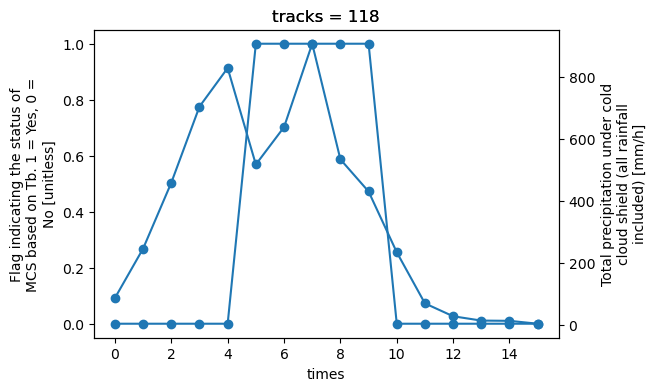

In [165]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
data_outtrack.isel(tracks=16).mcs_status.plot(ax=ax,marker='o')
ax2 = ax.twinx()
data_outtrack.isel(tracks=16).total_rain.plot(ax=ax2,marker='o')

In [200]:
mcsids[:10]

array([ 55., 130., 144., 145., 146., 158., 169., 171., 197., 210.])

In [192]:
data_mcs_missing = data_track.sel(tracks=mcsids)

In [201]:
data_mcs_missing.isel(tracks=5).mcs_duration.values

array(4)

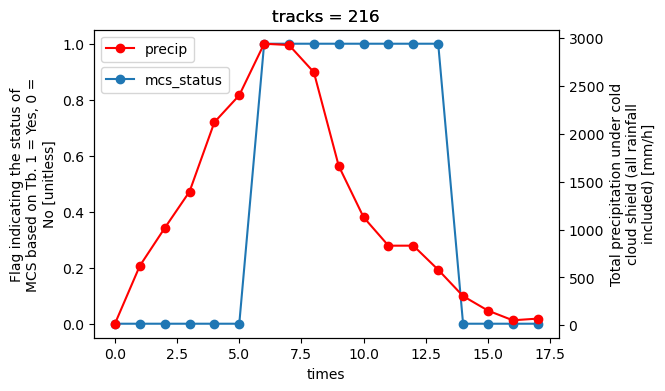

In [181]:
#16
fig,ax = plt.subplots(1,1,figsize=(6,4))
data_mcs_missing.isel(tracks=10).mcs_status.plot(ax=ax,marker='o', label='mcs_status')
ax2 = ax.twinx()
data_mcs_missing.isel(tracks=10).total_rain.plot(ax=ax2,marker='o', color='r', label='precip')
ax.legend(loc=2,bbox_to_anchor=[0,0.9])
ax2.legend(loc=2)

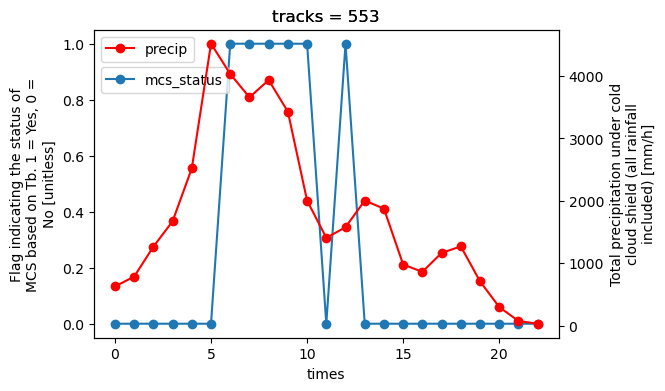

In [208]:
#16
fig,ax = plt.subplots(1,1,figsize=(6,4))
data_mcs_missing.isel(tracks=30).mcs_status.plot(ax=ax,marker='o', label='mcs_status')
ax2 = ax.twinx()
data_mcs_missing.isel(tracks=30).total_rain.plot(ax=ax2,marker='o', color='r', label='precip')
ax.legend(loc=2,bbox_to_anchor=[0,0.9])
ax2.legend(loc=2)